In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PREFERRED = "Preferred Semantics - Average"
GROUNDED = "Grounded Semantics - Average"
CATEGORISER = "Categoriser - Average"

In [2]:
def int_to_float(df):
    for col in df.columns:
        # Check if the column type is int64
        if df[col].dtype == 'int64':
            # Convert to float64
            df[col] = df[col].astype('float64')

In [3]:
def round_values(df):
    def replace_values(x):

        if np.isnan(x):
            return x

        # If it is 0.5, do not change
        if abs(x - 0.5) < 0.0001:
            return np.nan

        # Round down or up
        if x < 0.5:
            return 0
        else:
            return 1
    
    df[PREFERRED] = df[PREFERRED].apply(replace_values)
    df[GROUNDED] = df[GROUNDED].apply(replace_values)
    df[CATEGORISER] = df[CATEGORISER].apply(replace_values)

In [4]:
def performance_stats(df, results):

    target = "GroundTruth"

    for col in df.columns:
        if col in ["ID", target]:
            continue
        
        # Undecided cases do no enter in the statistics
        filtered_df = df.dropna(subset=[target, col])

        # Calculate True Positives, False Positives, True Negatives, and False Negatives
        tp = ((filtered_df[target] == 1) & (filtered_df[col] == 1)).sum()
        fp = ((filtered_df[target] == 0) & (filtered_df[col] == 1)).sum()
        tn = ((filtered_df[target] == 0) & (filtered_df[col] == 0)).sum()
        fn = ((filtered_df[target] == 1) & (filtered_df[col] == 0)).sum()

        # Calculate Precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        # Calculate Recall
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Calculate Specificity
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Calculate Youden's Index
        youden_index = recall + specificity - 1

        # Calculate Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

        # Calculate percentage of NAs
        percent_na = 1 - len(filtered_df)/len(df)

        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["Youden's Index"].append(youden_index)
        results["Accuracy"].append(accuracy)
        results["Percent NA"].append(percent_na)
        
        # Display the metrics
        # print(f"\n{col}")
        # print(f"Precision: {precision}")
        # print(f"Recall: {recall}")
        # print(f"Youden's Index: {youden_index}")
        # print(f"Accuracy: {accuracy}")
        # print(f"Percent NA: {percent_na:.2f}")

In [5]:
def percent_nas(df):
    nan_count = df.isna().sum()

    # Calculate the total number of entries in each column
    total_count = len(df)

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_count / total_count) * 100

    # Display the percentage of NaN values
    print("\nPercentage of NaN values in each column:")
    print(nan_percentage)

In [6]:
def unique_values(df, display = False):
    # Initialize a dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column in the DataFrame
    for col in df.columns:
        if col == "ID":
            continue
        unique_values_dict[col] = df[col].unique()

    if not display:
        return
    
    # Display the unique values for each column
    for col, unique_values in unique_values_dict.items():
        print(f"Unique values in column '{col}': {unique_values}")

In [7]:
def rulex_results(dataset, conditions, error):

    results = {"Precision": [], "Recall": [],
               "Youden's Index": [], "Accuracy": [], "Percent NA": []}

    rulex_df = pd.read_csv("./data/rulex_performance.csv")
    rulex_df['Base'] = rulex_df['Base'].str.strip()
    rulex_df['Conditions'] = rulex_df['Conditions'].astype(str).str.strip()
    rulex_df['Error'] = rulex_df['Error'].astype(str).str.strip()

    for e in error:

        filtered_df = rulex_df[(rulex_df['Base'] == dataset) & (rulex_df['Conditions'] == conditions) & (rulex_df['Error'] == e)]
        for index, row in filtered_df.iterrows():
            # # Repetition. Can be necessary to compare the same result with multiple others
            # for _ in range(4):
            results["Precision"].append(row['Precision'])
            results["Recall"].append(row['Recall'])
            results["Youden's Index"].append(row['Youden'])
            results["Accuracy"].append(row['Accuracy'])
            results["Percent NA"].append(row['Nas'])

    results_df = pd.DataFrame(results, index=["10_error_rulex", "25_error_rulex"])
    return results_df

In [8]:
def get_results_df(all_data):
    results_dict = {"Precision":[], "Recall":[], "Youden's Index":[], "Accuracy":[], "Percent NA":[]}

    for df in all_data:
        performance_stats(df, results_dict)

    bases =  ['base_10', 'base_15', 'base_20', 'base_25']
    semantics = ['preferred', 'categoriser', 'grounded']
    row_names = []

    for base in bases:
        for semantic in semantics:
            row_names.append(base + "_" + semantic)
    results_df = pd.DataFrame(results_dict, index=row_names)


    bases =  ['base_10', 'base_15', 'base_20', 'base_25']
    semantics = ['preferred', 'categoriser', 'grounded']
    order = []

    for semantic in semantics:
        for base in bases:
            order.append(base + "_" + semantic)
    
    return results_df.loc[order]

In [9]:
def get_results_df_ib(all_data):
    results_dict = {"Precision":[], "Recall":[], "Youden's Index":[], "Accuracy":[], "Percent NA":[]}

    for df in all_data:
        performance_stats(df, results_dict)

    bases =  ['10_error', '25_error']
    budgets = ['25_budget', '50_budget', '90_budget', '100_budget']
    semantics = ['preferred', 'categoriser', 'grounded']
    row_names = []

    for budget in budgets:
        for base in bases:
            for semantic in semantics:
                row_names.append(budget + "_" + base + "_" + semantic)
    results_df = pd.DataFrame(results_dict, index=row_names)


    order = []
    for semantic in semantics:
        for base in bases:
            for budget in budgets:
                order.append(budget + "_" + base + "_" + semantic)
    
    return results_df.loc[order]

In [10]:
# root_folder = "./data/Adult/framework results/"
# base_10 = pd.read_csv(root_folder + "adult_base_10_rebuttal.csv")
# base_15 = pd.read_csv(root_folder + "adult_base_15_rebuttal.csv")
# base_20 = pd.read_csv(root_folder + "adult_base_20_rebuttal.csv")
# base_25 = pd.read_csv(root_folder + "adult_base_25_rebuttal.csv")

# all_data = [("base_10", base_10), ("base_15", base_15), ("base_20", base_20), ("base_25", base_25)]
# for _, df in all_data:
#     int_to_float(df)
#     round_values(df)
#     unique_values(df)

In [11]:
# root_folder = "./data/Cars/results framework/"
# base_10 = pd.read_csv(root_folder + "cars_base_10_rebuttal.csv")
# base_15 = pd.read_csv(root_folder + "cars_base_15_rebuttal.csv")
# base_20 = pd.read_csv(root_folder + "cars_base_20_rebuttal.csv")
# base_25 = pd.read_csv(root_folder + "cars_base_25_rebuttal.csv")

# # root_folder = "./data/Cars/4_conditionals/results framework/"
# # base_10 = pd.read_csv(root_folder + "cars_4_base_10_rebuttal.csv")
# # base_15 = pd.read_csv(root_folder + "cars_4_base_15_rebuttal.csv")
# # base_20 = pd.read_csv(root_folder + "cars_4_base_20_rebuttal.csv")
# # base_25 = pd.read_csv(root_folder + "cars_4_base_25_rebuttal.csv")


# all_data = [("base_10", base_10), ("base_15", base_15), ("base_20", base_20), ("base_25", base_25)]
# for _, df in all_data:
#     int_to_float(df)
#     round_values(df)
#     unique_values(df)

# results_df = get_results_df('cars', all_data)

In [12]:
# root_folder = "./data/Myocardial/results framework/"
# base_10 = pd.read_csv(root_folder + "myocardial_base_10_rebuttal.csv")
# base_15 = pd.read_csv(root_folder + "myocardial_base_15_rebuttal.csv")
# base_20 = pd.read_csv(root_folder + "myocardial_base_20_rebuttal.csv")
# base_25 = pd.read_csv(root_folder + "myocardial_base_25_rebuttal.csv")


# all_data = [("base_10", base_10), ("base_15", base_15), ("base_20", base_20), ("base_25", base_25)]
# for _, df in all_data:
#     int_to_float(df)
#     round_values(df)
#     unique_values(df)

# results_df = get_results_df('myocardial', all_data)

In [13]:
# # base = 'bank'
# # conditions = '4'
# # #conditions = 'unlimited'

# # base = 'cars'
# # conditions = '4'
# # # #conditions = 'unlimited'

# # base = 'adult'
# # conditions = '4'
# # conditions = 'unlimited'

# base = 'myocardial'
# conditions = '4'
# # #conditions = 'unlimited'

# root_folder = "./data/" + base.capitalize() + "/" + conditions + '_conditions/results framework/'
# base_10 = pd.read_csv(root_folder + base + "_4_base_10_rebuttal.csv")
# base_15 = pd.read_csv(root_folder + base + "_4_base_15_rebuttal.csv")
# base_20 = pd.read_csv(root_folder + base + "_4_base_20_rebuttal.csv")
# base_25 = pd.read_csv(root_folder + base + "_4_base_25_rebuttal.csv")


# all_data = [("base_10", base_10), ("base_15", base_15), ("base_20", base_20), ("base_25", base_25)]
# for _, df in all_data:
#     int_to_float(df)
#     round_values(df)
#     unique_values(df)

# results_df = get_results_df(base, all_data)
# results_df = pd.concat([results_df, rulex_results(base, conditions, [10, 15, 20, 25])])

# print(results_df)

In [14]:
# df = results_df

# bases = ['base_10', 'base_15', 'base_20', 'base_25']
# # Determine the number of columns in the dataframe for creating the grid layout
# num_columns = len(df.columns)
# num_bases = len(bases)

# fig, axes = plt.subplots(nrows=num_bases, ncols=num_columns, figsize=(16, num_bases * 4))

# # Flatten the axes array for easy iteration if it's multi-dimensional
# axes = axes.flatten()

# colors = ['#2c7bb6'] * 1 + ['#00a6ca'] * 1 + ['#00ccbc'] * 1 + ['#90eb9d'] * 1

# # Counter for the subplot index
# plot_idx = 0

# for base in bases:
#     base_df = df[df.index.str.contains(base)]
    
#     for i, column in enumerate(base_df.columns):
#         ax = axes[plot_idx]
#         ax.barh(base_df.index, base_df[column], height=0.6, color=colors)

#         # Draw a horizontal line at the first bar length
#         first_bar_length = base_df[column].iloc[3]
#         ax.axvline(x=first_bar_length, color='red', linestyle='--')

#         ax.set_title(f'{column}')
#         ax.set_xlabel('Value')
#         if i == 0:  # Include row names only in the first columns
#             ax.set_ylabel('Index')
#         else:
#             ax.set_yticklabels([])  # Hide y-axis labels for other columns
#         plot_idx += 1

# plt.tight_layout()
# plt.show()

In [15]:

df = pd.read_csv("./data_2/Adult/4_score_conditions/results framework/25_budget/adult_score_base_25_rebuttal_25.csv", na_values='NaN')
df.head()

,ID,GroundTruth,Preferred Semantics - Average,Categoriser - Average,Grounded Semantics - Average
0,0,0,0.0,0.0,0.0
1,1,0,NaN,NaN,NaN
2,2,0,0.0,0.0,0.0
3,3,0,NaN,NaN,NaN
4,4,0,NaN,NaN,NaN


In [16]:
base = 'adult'
# base = 'myocardial'
# base = 'cars'
# base = 'bank'

# conditions = '4'
# conditions = 'unlimited'
conditions = '4_score_conditions'

root_folder = "./data_2/" + base.capitalize() + "/" + conditions + '/results framework/'

budgets = ['25_budget', '50_budget', '90_budget', '100_budget']
#budgets = ['25_budget']

all_data = []

for budget in budgets:
    for error in ["10", "25"]:
    #for error in ["10"]:
        df = pd.read_csv(root_folder + budget + "/" + base + "_score_base_" + error + "_rebuttal_" + budget.split("_")[0] + ".csv", na_values='NaN')
        # print(root_folder + budget + "/" + base + "_score_base_" + error + "_rebuttal_" + budget.split("_")[0] + ".csv")
        # df.to_csv('output_teste_export_' + error + '.csv', index=True)
        int_to_float(df)
        round_values(df)
        unique_values(df)

        all_data.append(df)
        #df.to_csv('output_teste_' + error + '.csv', index=True)


results_df = get_results_df_ib(all_data)
results_df = pd.concat([results_df, rulex_results(base, "4", ["10", "25"])])


index={'25_budget_10_error_preferred': 'AP1',
       '50_budget_10_error_preferred': 'AP2',
       '90_budget_10_error_preferred': 'AP3', 
       '100_budget_10_error_preferred': 'AP4', 
       '25_budget_25_error_preferred': 'AP5',
       '50_budget_25_error_preferred': 'AP6',
       '90_budget_25_error_preferred': 'AP7', 
       '100_budget_25_error_preferred': 'AP8',
       '25_budget_10_error_categoriser': 'AG1',
       '50_budget_10_error_categoriser': 'AG2',
       '90_budget_10_error_categoriser': 'AG3', 
       '100_budget_10_error_categoriser': 'AG4', 
       '25_budget_25_error_categoriser': 'AG5',
       '50_budget_25_error_categoriser': 'AG6',
       '90_budget_25_error_categoriser': 'AG7', 
       '100_budget_25_error_categoriser': 'AG8',
       '25_budget_10_error_grounded': 'AC1',
       '50_budget_10_error_grounded': 'AC2',
       '90_budget_10_error_grounded': 'AC3', 
       '100_budget_10_error_grounded': 'AC4', 
       '25_budget_25_error_grounded': 'AC5',
       '50_budget_25_error_grounded': 'AC6',
       '90_budget_25_error_grounded': 'AC7', 
       '100_budget_25_error_grounded': 'AC8',
       '10_error_rulex': 'H1',
       '25_error_rulex': 'H2'
       }

results_df.rename(index=index, inplace=True)


results_df.to_csv('output.csv', index=True)
results_df

,Precision,Recall,Youden's Index,Accuracy,Percent NA
AP1,0.603535,0.811392,0.659880,0.840277,0.205822
AP2,0.570248,0.762786,0.572268,0.797858,0.000000
AP3,0.593486,0.828881,0.648350,0.821740,0.151150
AP4,0.625052,0.808499,0.659192,0.840761,0.221106
AP5,0.437366,0.715110,0.521246,0.790292,0.241131
AP6,0.520490,0.815397,0.566434,0.767058,0.000000
AP7,0.370245,0.949284,0.234526,0.488997,0.305451
AP8,0.370292,0.952046,0.225443,0.483621,0.314800
AG1,0.603535,0.811392,0.659880,0.840277,0.205822
AG2,0.570248,0.762786,0.572268,0.797858,0.000000


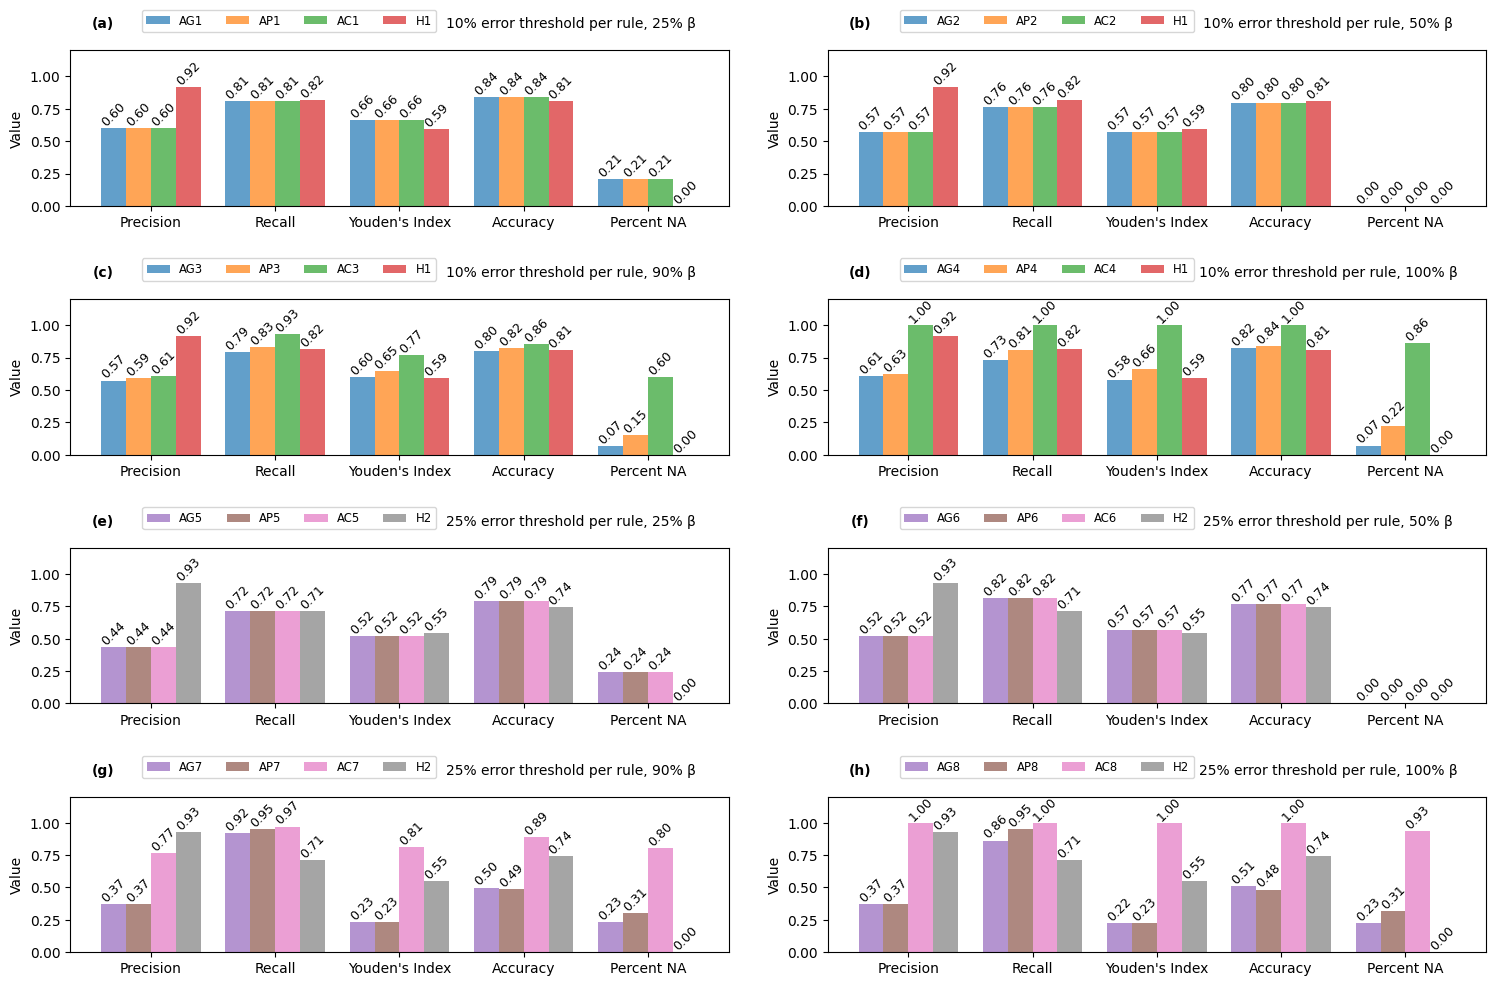

In [24]:
df = results_df

# Define groups
groups = [
    (['AG1', 'AP1', 'AC1', 'H1']),
    (['AG2', 'AP2', 'AC2', 'H1']),
    (['AG3', 'AP3', 'AC3', 'H1']),
    (['AG4', 'AP4', 'AC4', 'H1']),
    (['AG5', 'AP5', 'AC5', 'H2']),
    (['AG6', 'AP6', 'AC6', 'H2']),
    (['AG7', 'AP7', 'AC7', 'H2']),
    (['AG8', 'AP8', 'AC8', 'H2'])
]

# Create a figure with 8 subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Define colors for each group
colors_group1 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors_group2 = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

inconsistency_budget = ["25%", "50%", "90%", "100%"] * 2
error_threshold = ["10%"] * 4 + ["25%"] * 4

label = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

# Plot each group
for i, group in enumerate(groups):
    group_df = df.loc[group]

    # Transpose the dataframe to have metrics as columns and indexes as rows
    group_df = group_df.T

    # Determine colors for the current group
    colors = colors_group1 if i < 4 else colors_group2

    # Plot the grouped bar plot
    ax = group_df.plot(kind='bar', ax=axes[i], width=0.8, alpha=0.7, color=colors)
    axes[i].set_ylabel('Value')
    axes[i].set_ylim(0, 1.2)
    axes[i].set_xticklabels(group_df.index, rotation=0, ha='center')

    # Annotate each bar with its height
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9.5, rotation=45)

    # Set legend for the current subplot (horizontal below the plot)
    handles, labels = ax.get_legend_handles_labels()
    axes[i].text(0.05, 1.17, label[i], transform=axes[i].transAxes, fontsize=10, ha='center', va='center', fontweight='bold')

    axes[i].legend(handles, labels, loc='upper right', bbox_to_anchor=(0.565, 1.3), ncol=len(labels), fontsize='small')
    # Add text below the legend
    axes[i].text(0.76, 1.17, error_threshold[i] + " error threshold per rule, " + inconsistency_budget[i] + " β", transform=axes[i].transAxes, fontsize=10, ha='center', va='center')

plt.tight_layout()

# Adjust vertical space between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.15)

# Adjust layout and save the plot
plt.savefig(base + '.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# df = results_df

# bases = ['10_error', '25_error']
# budgets = ["25_budget", "50_budget", "90_budget", "100_budget"]

# # bases = ['10_error']
# # budgets = ["25_budget"]

# # Determine the number of columns in the dataframe for creating the grid layout
# num_columns = len(df.columns)
# num_rows = (len(budgets) * len(bases))  # Want to see all budgets compared to the rulex with same error

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(16, (len(budgets) + 1) * 4))

# # Flatten the axes array for easy iteration if it's multi-dimensional
# axes = axes.flatten()

# colors = ['#2c7bb6'] * 1 + ['#00a6ca'] * 1 + ['#00ccbc'] * 1 + ['#90eb9d'] * 1 + ['#00008B'] * 1

# # Counter for the subplot index
# plot_idx = 0

# for base in bases:
#     for budget in budgets:
#         budget_df = df[df.index.str.contains(base)]
#         budget_df = budget_df[budget_df.index.str.contains(budget)]
#         budget_df = pd.concat([budget_df, df[df.index.str.contains(base + "_rulex")]])

#         # print(budget_df)
#         # print()

#         for i, column in enumerate(budget_df.columns):
#             #ax = axes[plot_idx]
#             #print(column, budget_df[column])
            
#             ax = axes[plot_idx]
#             ax.barh(budget_df.index, budget_df[column], height=0.6, color=colors)

#             # Draw a horizontal line at the first bar length
#             # first_bar_length = budget_df[column].iloc[3]
#             # ax.axvline(x=first_bar_length, color='red', linestyle='--')

#             ax.set_title(f'{column}')
#             ax.set_xlabel('Value')
#             if i == 0:  # Include row names only in the first columns
#                 ax.set_ylabel('Index')
#             else:
#                 ax.set_yticklabels([])  # Hide y-axis labels for other columns
#             plot_idx += 1
#             #print(plot_idx)

# plt.tight_layout()
# plt.show()

In [19]:
# 